In [2]:
!pip install pydub
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pylab
import keras
import tensorflow
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


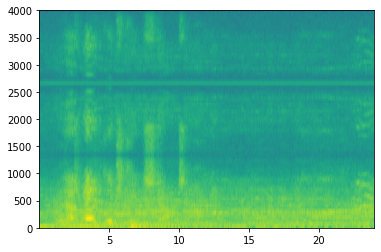

In [ ]:
x = graph_spectrogram("/content/train.wav")

In [ ]:
_, data = wavfile.read("/content/train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (192000,)
Time steps in input after spectrogram (101, 2398)


In [4]:
Tx = 2203 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [5]:
Ty = 548 # The number of time steps in the output of our model

In [6]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio()

print("background len: " + str(len(backgrounds[0])))    # Should be 10,000, since it is a 10 sec clip
print("activate[0] len: " + str(len(activates[0])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("activate[1] len: " + str(len(activates[1])))     # Different "activate" clips can have different lengths 

background len: 4000
activate[0] len: 460
activate[1] len: 880


In [7]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [8]:
# GRADED FUNCTION: is_overlapping

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 line)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    ### END CODE HERE ###

    return overlap

In [9]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


**Expected Output**:

<table>
    <tr>
        <td>
            **Overlap 1**
        </td>
        <td>
           False
        </td>
    </tr>
    <tr>
        <td>
            **Overlap 2**
        </td>
        <td>
           True
        </td>
    </tr>
</table>

In [10]:
# GRADED FUNCTION: insert_audio_clip

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [ ]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Segment Time:  (2915, 3374)


**Expected Output**

<table>
    <tr>
        <td>
            **Segment Time**
        </td>
        <td>
           (2254, 3169)
        </td>
    </tr>
</table>

In [11]:
# GRADED FUNCTION: insert_ones

def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

In [12]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 4000ms
    padding = AudioSegment.silent(duration=4000)
    segment = AudioSegment.from_wav(filename)[:4000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

# GRADED FUNCTION: create_training_example
def create_training_example(background, activates, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make background quieter
    background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 3)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end_ms=segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    preprocess_audio("train.wav")
    print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your directory.
File (train.wav) was saved in your

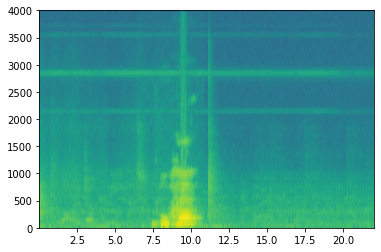

In [ ]:
X = []
Y = []
for i in range(1, 201):
  background_index = np.random.randint(0, len(backgrounds))
  x, y = create_training_example(backgrounds[0], activates, negatives)
  
  # If maximum length exceeds mfcc lengths then pad the remaining ones
  if (x.shape[1] < Tx):
    pad_width = Tx - x.shape[1]
    x = np.pad(x, pad_width=((0, 0), (0, pad_width)), mode='constant')
  # Else cutoff the remaining parts
  elif (x.shape[1] > Tx):
    x = x[:, :Tx]
  X.append(x)
  Y.append(y)
X = np.array(X)
Y = np.array(Y)

In [ ]:
print(X.shape)
X = X.reshape(X.shape[0], X.shape[2], X.shape[1])
print(X.shape)
Y = Y.reshape(Y.shape[0], Y.shape[2],  Y.shape[1])
print(Y.shape)

(200, 101, 2203)
(200, 2203, 101)
(200, 548, 1)


Now you can listen to the training example you created and compare it to the spectrogram generated above.

In [ ]:
IPython.display.Audio("train.wav")

In [13]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Flatten
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [ ]:
# GRADED FUNCTION: model

def getModel():
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """

    model = Sequential()
    model.add(Conv1D(512, kernel_size=15, strides=4, input_shape=(Tx, n_freq)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.8))

    model.add(GRU(units = 256, return_sequences = True))
    model.add(Dropout(0.8))
    model.add(BatchNormalization())

    model.add(GRU(units = 256, return_sequences = True))
    model.add(Dropout(0.8))
    model.add(BatchNormalization())
    model.add(Dropout(0.8))

    model.add(TimeDistributed(Dense(1, activation = "sigmoid")))
    
    return model  

In [ ]:
model = getModel()

Let's print the model summary to keep track of the shapes.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 548, 512)          776192    
                                                                 
 batch_normalization_3 (Batc  (None, 548, 512)         2048      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 548, 512)          0         
                                                                 
 dropout_4 (Dropout)         (None, 548, 512)          0         
                                                                 
 gru_2 (GRU)                 (None, 548, 256)          591360    
                                                                 
 dropout_5 (Dropout)         (None, 548, 256)          0         
                                                      

In [ ]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Ruha_Model3')

In [ ]:
epochs = 1000
batch_size = 32
model.fit(X, Y, epochs=epochs, batch_size=batch_size)

Epoch 1/1000
7/7 [==============================] - 44s 6s/step - loss: 0.3043 - accuracy: 0.9160
Epoch 2/1000
7/7 [==============================] - 39s 5s/step - loss: 0.2929 - accuracy: 0.9176
Epoch 3/1000
7/7 [==============================] - 39s 5s/step - loss: 0.2899 - accuracy: 0.9178
Epoch 4/1000
7/7 [==============================] - 39s 6s/step - loss: 0.2867 - accuracy: 0.9178
Epoch 5/1000
7/7 [==============================] - 39s 6s/step - loss: 0.2848 - accuracy: 0.9177
Epoch 6/1000
7/7 [==============================] - 39s 6s/step - loss: 0.2846 - accuracy: 0.9176
Epoch 7/1000
7/7 [==============================] - 39s 6s/step - loss: 0.2843 - accuracy: 0.9176
Epoch 8/1000
7/7 [==============================] - 39s 6s/step - loss: 0.2828 - accuracy: 0.9177
Epoch 9/1000
7/7 [==============================] - 39s 6s/step - loss: 0.2833 - accuracy: 0.9177
Epoch 10/1000
7/7 [==============================] - 39s 6s/step - loss: 0.2824 - accuracy: 0.9177
Epoch 11/1000
7/7 [

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Ruha_Model3")

In [14]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Ruha_Model')

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


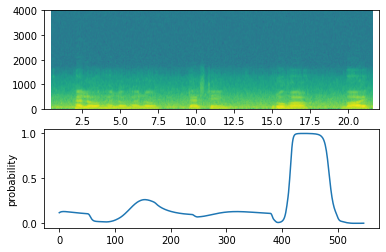

(1, 548, 1)


In [16]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 4000ms
    padding = AudioSegment.silent(duration=4000)
    segment = AudioSegment.from_wav(filename)[:4000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    x = graph_spectrogram(filename)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (x.shape[1] < Tx):
      pad_width = Tx - x.shape[1]
      x = np.pad(x, pad_width=((0, 0), (0, pad_width)), mode='constant')
    # Else cutoff the remaining parts
    elif (x.shape[1] > Tx):
      x = x[:, :Tx]

    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

preprocess_audio("/content/test1.wav")
print(detect_triggerword("/content/test1.wav").shape)

In [106]:
chime_file = "/content/chime.wav"
def chime_on_activate(filename, predictions, threshold):
  audio_clip = AudioSegment.from_wav(filename)
  chime = AudioSegment.from_wav(chime_file)
  Ty = predictions.shape[1]
  # Step 1: Initialize the number of consecutive output steps to 0
  consecutive_timesteps = 0
  # Step 2: Loop over the output steps in the y
  for i in range(Ty):
    # Step 3: Increment consecutive output steps
    if predictions[0,i,0] > threshold:
      consecutive_timesteps += 1
    elif predictions[0,i,0] < threshold:
      consecutive_timesteps = 0
    # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
    if consecutive_timesteps > 56:
      # Step 5: Superpose audio and background using pydub
      audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
      # Step 6: Reset consecutive output steps to 0
      break
      
  audio_clip.export("chime_output.wav", format='wav')

In [71]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Ruha_Model')

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


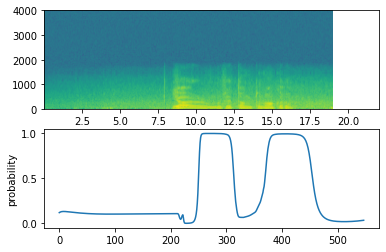

In [108]:
filename = "/content/test5.wav"
preprocess_audio(filename)
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.9)
IPython.display.Audio("/content/chime_output.wav")

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


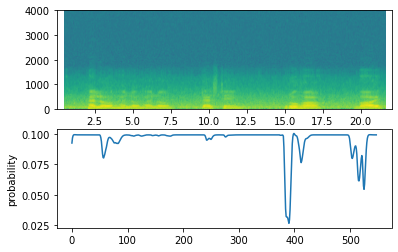

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Ruha_Model3')
filename = "/content/test1.wav"
preprocess_audio(filename)
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.95)
IPython.display.Audio("/content/chime_output.wav")

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


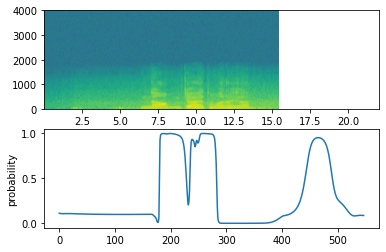

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Ruha_Model2')
filename = "/content/test6.wav"
preprocess_audio(filename)
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.95)
IPython.display.Audio("/content/chime_output.wav")